In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam


In [0]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [0]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_170 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_227 (Dense)            (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_171 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dense_228 (Dense)            (None, 784)               803600    
Total para

In [0]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_229 (Dense)            (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_172 (LeakyReLU)  (None, 1024)              0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_230 (Dense)            (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_173 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 256)               131328    
__________

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_57 (Sequential)   (None, 784)               1486352   
_________________________________________________________________
sequential_58 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)

Output hidden; open in https://colab.research.google.com to view.

Epoc nª   1
Epoc nª   2
Epoc nª   3
Epoc nª   4
Epoc nª   5
Epoc nª   6
Epoc nª   7
Epoc nª   8
Epoc nª   9
Epoc nª   10
Epoc nª   11
Epoc nª   12
Epoc nª   13
Epoc nª   14
Epoc nª   15
Epoc nª   16
Epoc nª   17
Epoc nª   18
Epoc nª   19
Epoc nª   20
Epoc nª   21
Epoc nª   22
Epoc nª   23
Epoc nª   24
Epoc nª   25
Epoc nª   26
Epoc nª   27
Epoc nª   28
Epoc nª   29
Epoc nª   30
Epoc nª   31
Epoc nª   32
Epoc nª   33
Epoc nª   34
Epoc nª   35
Epoc nª   36
Epoc nª   37
Epoc nª   38
Epoc nª   39
Epoc nª   40
Epoc nª   41
Epoc nª   42
Epoc nª   43
Epoc nª   44
Epoc nª   45
Epoc nª   46
Epoc nª   47
Epoc nª   48
Epoc nª   49
Epoc nª   50
Epoc nª   51
Epoc nª   52
Epoc nª   53
Epoc nª   54
Epoc nª   55
Epoc nª   56
Epoc nª   57
Epoc nª   58
Epoc nª   59
Epoc nª   60
Epoc nª   61
Epoc nª   62
Epoc nª   63
Epoc nª   64
Epoc nª   65
Epoc nª   66
Epoc nª   67
Epoc nª   68
Epoc nª   69
Epoc nª   70
Epoc nª   71
Epoc nª   72
Epoc nª   73
Epoc nª   74
Epoc nª   75
Epoc nª   76
Epoc nª   77
Epoc nª 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


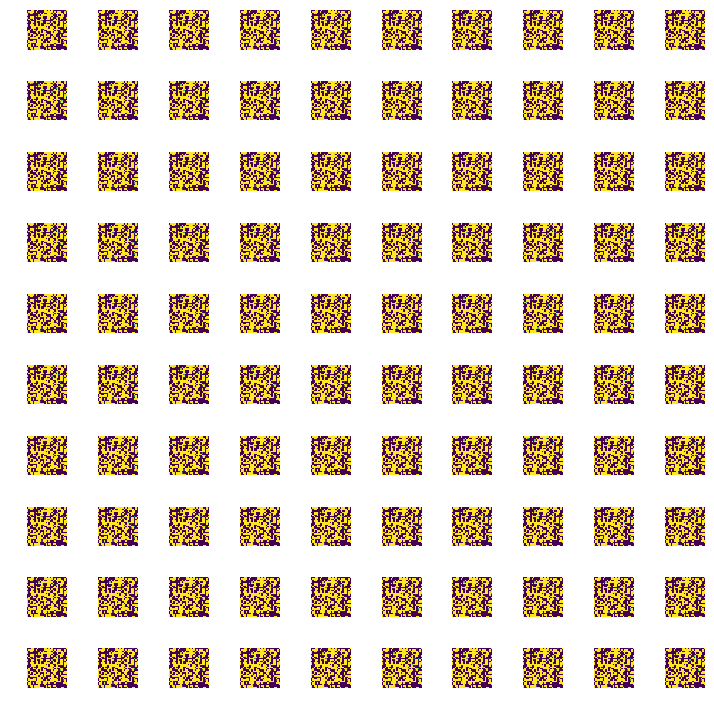

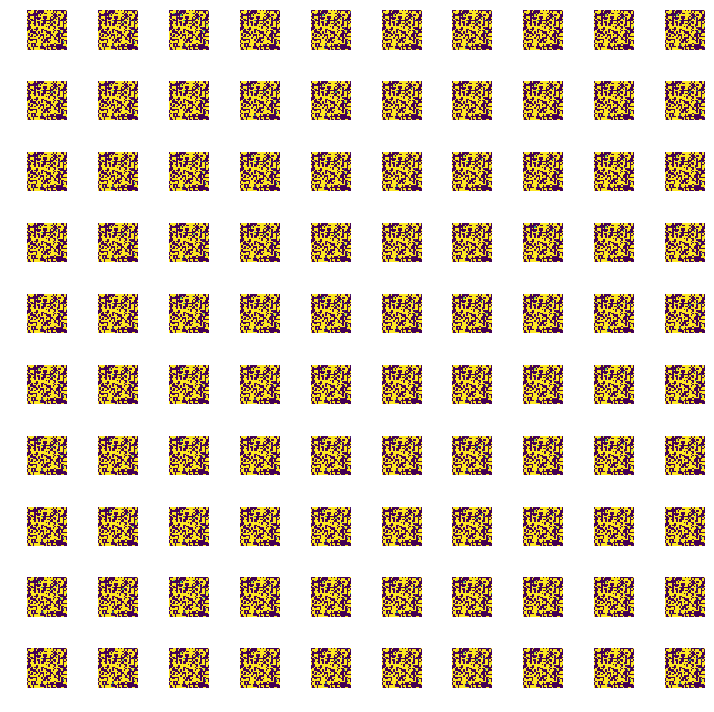

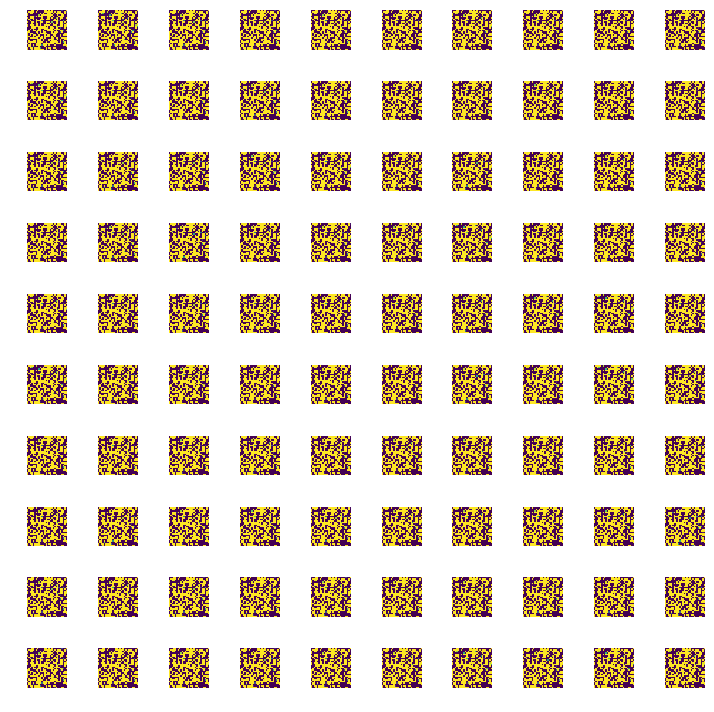

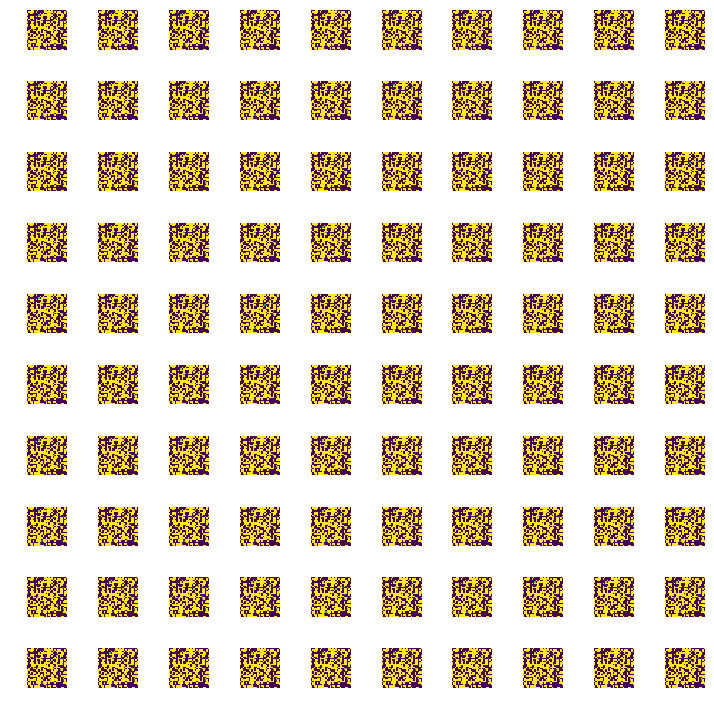

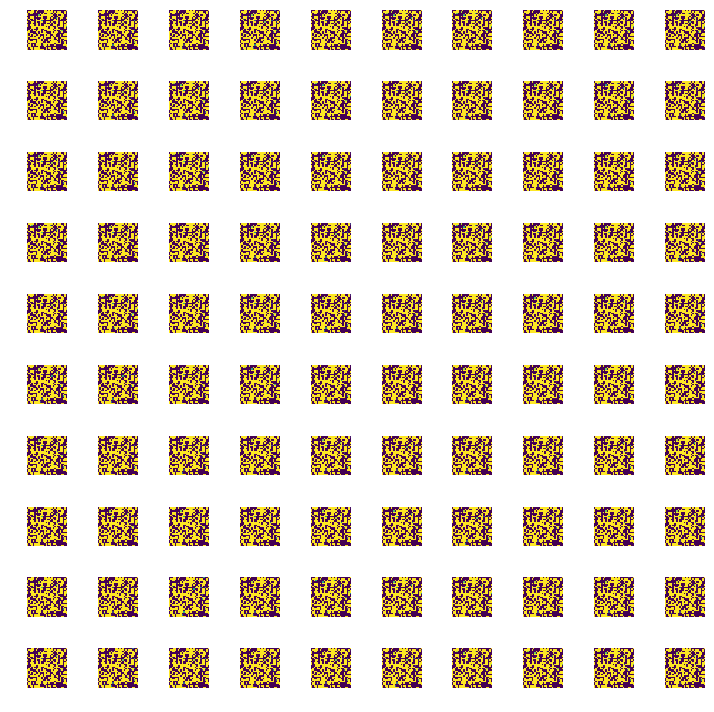

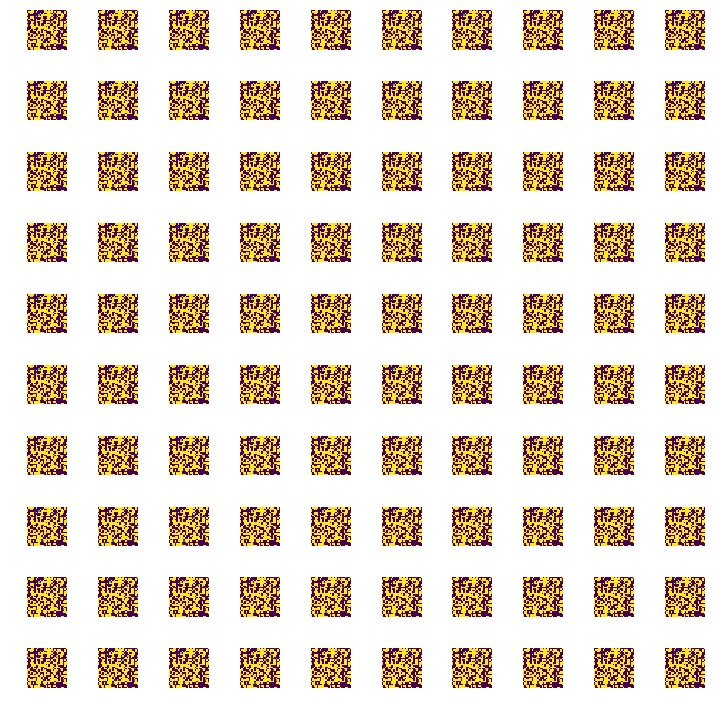

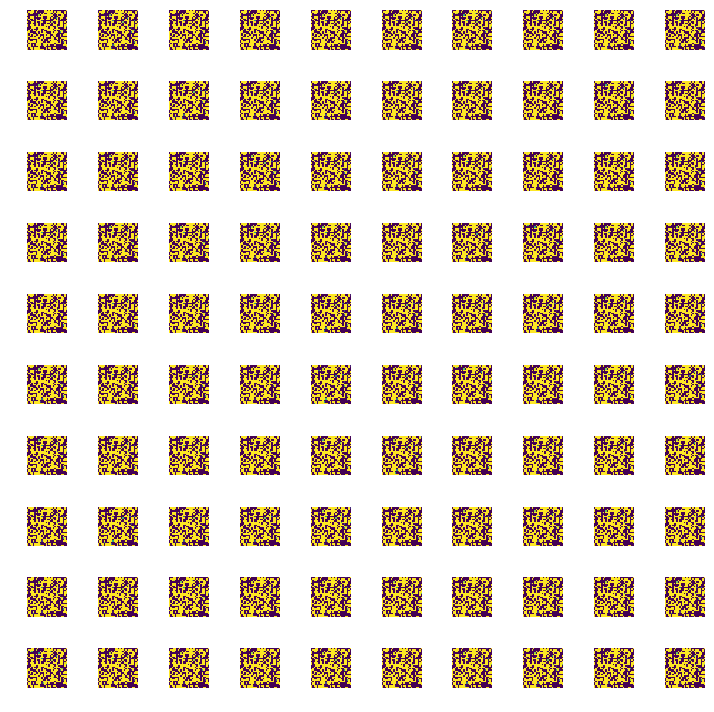

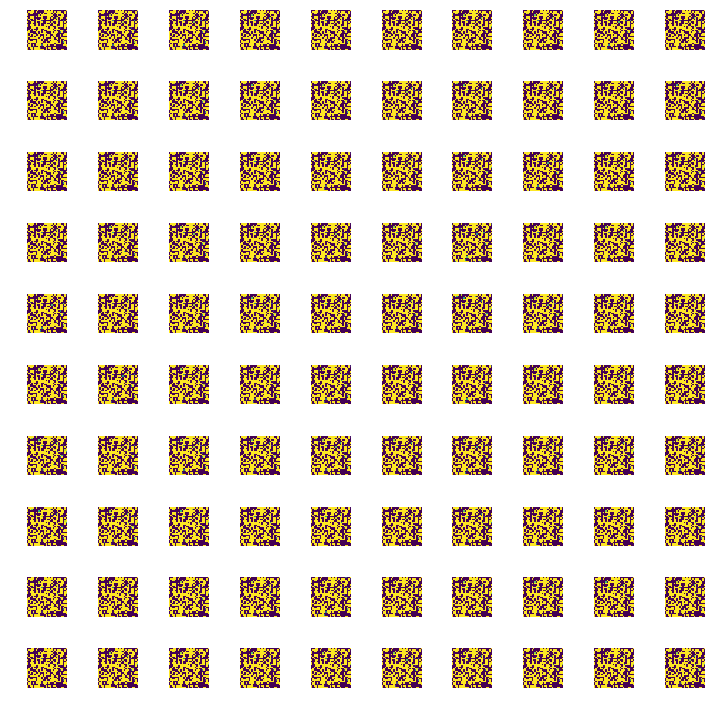

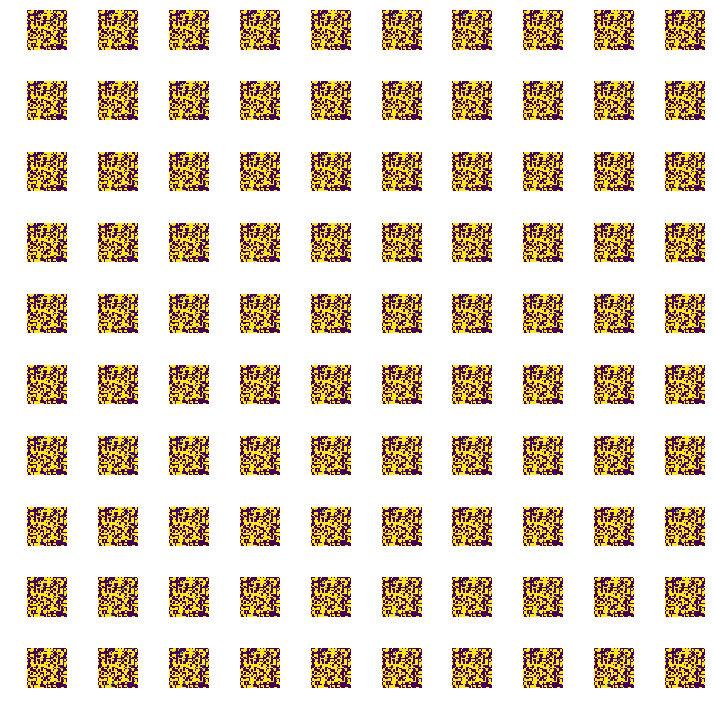

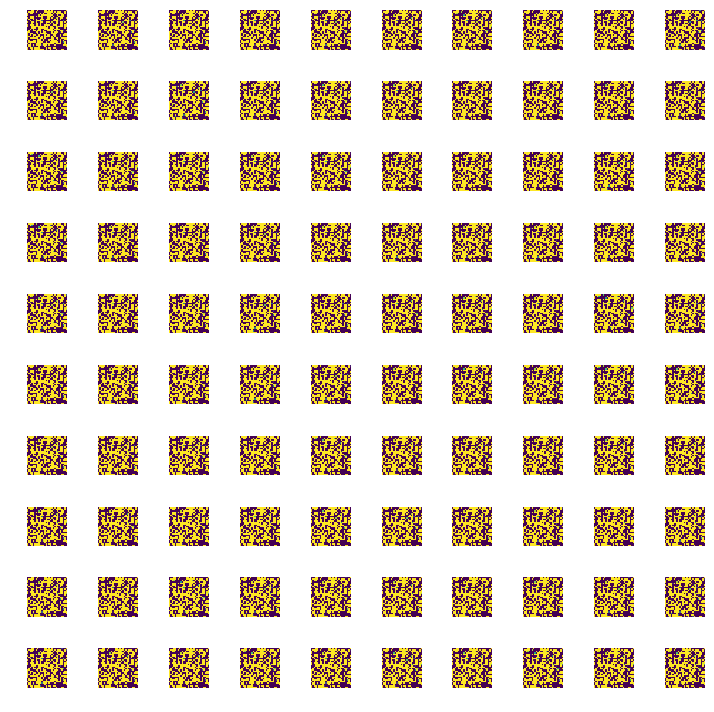

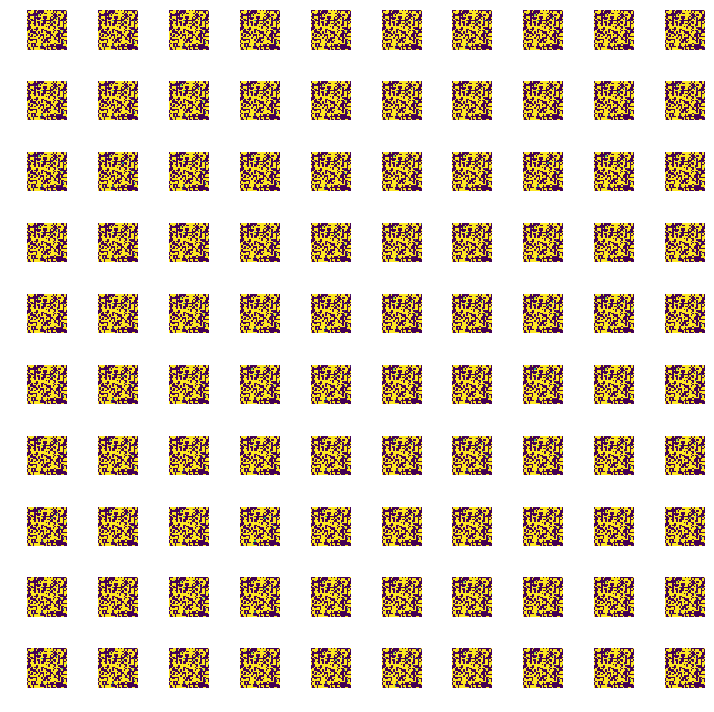

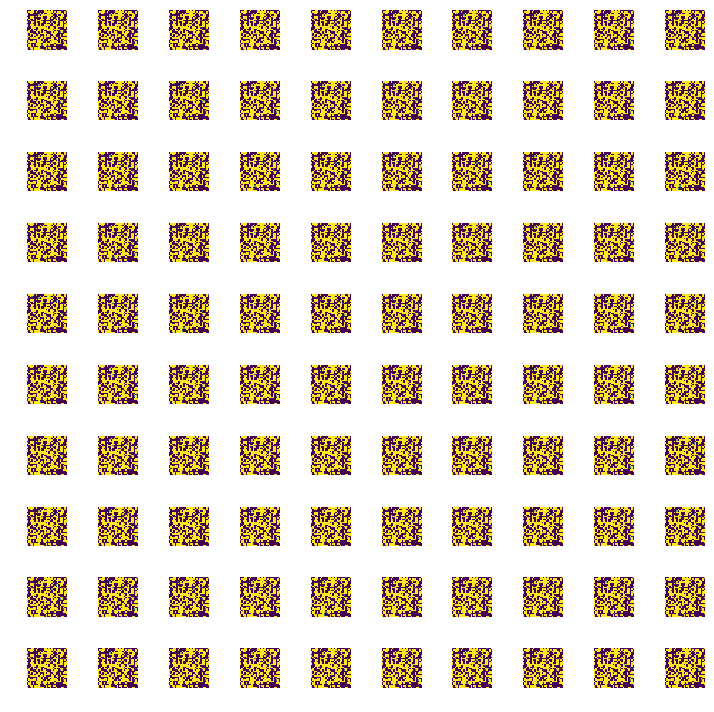

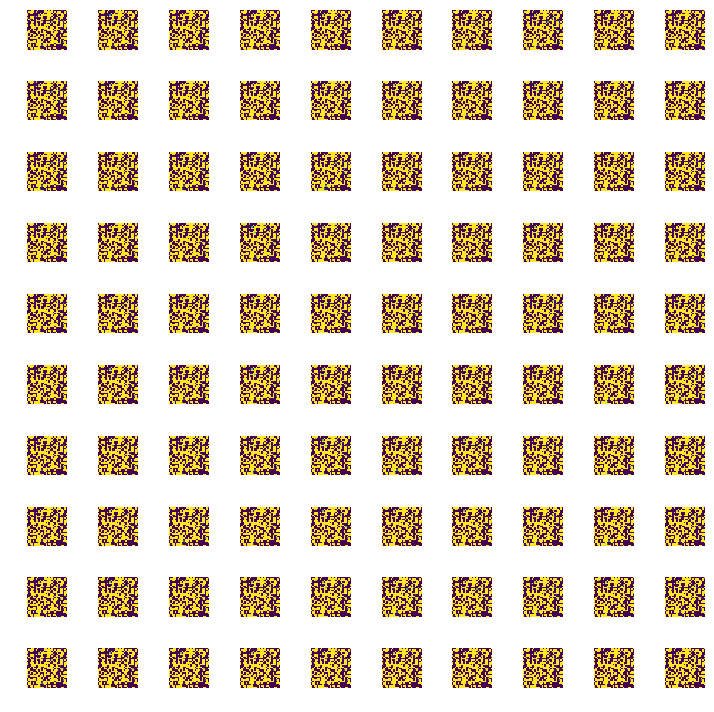

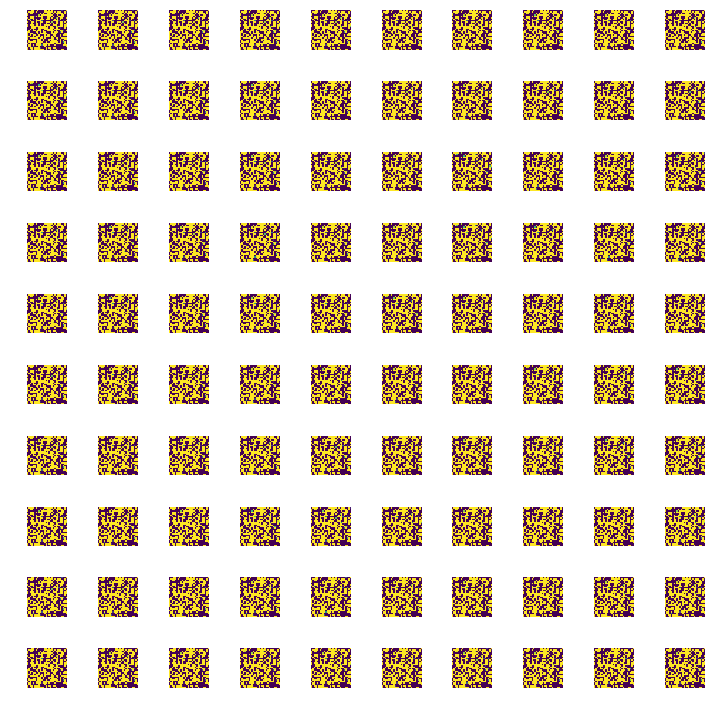

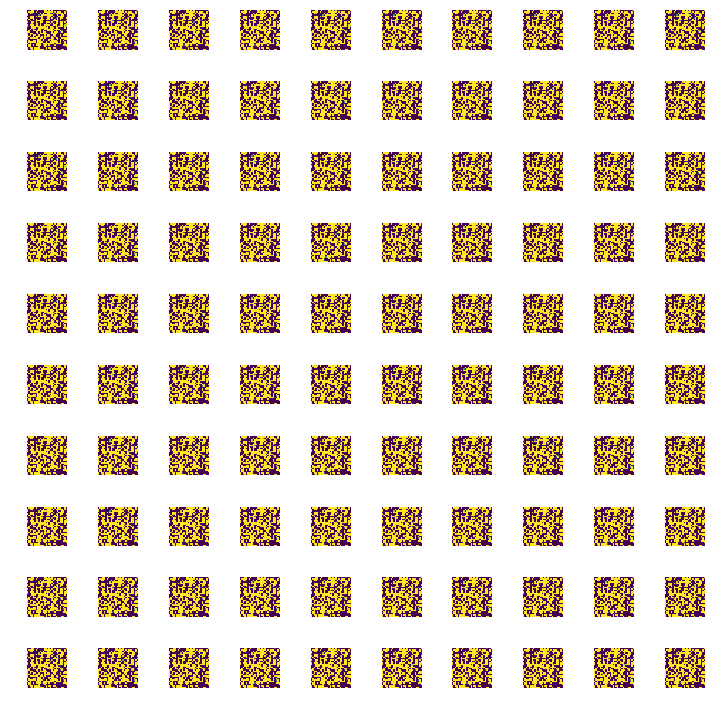

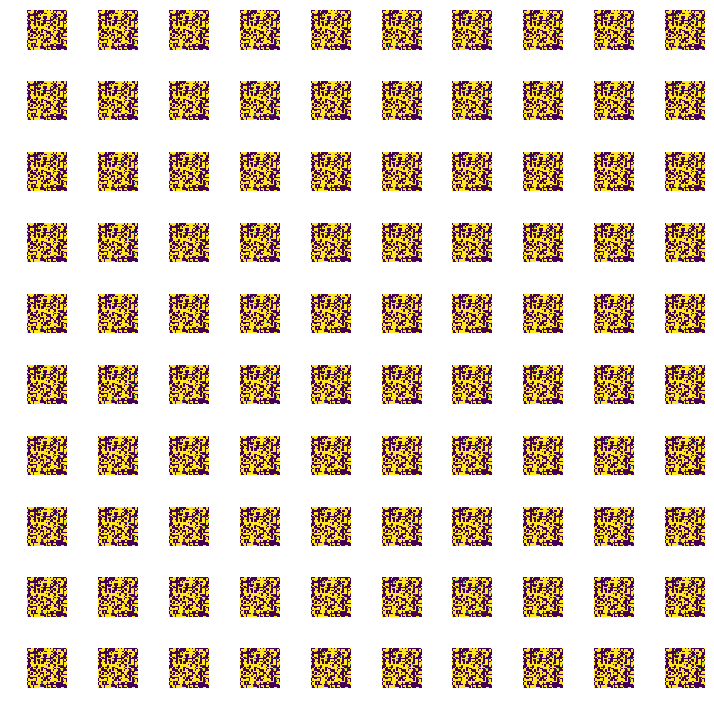

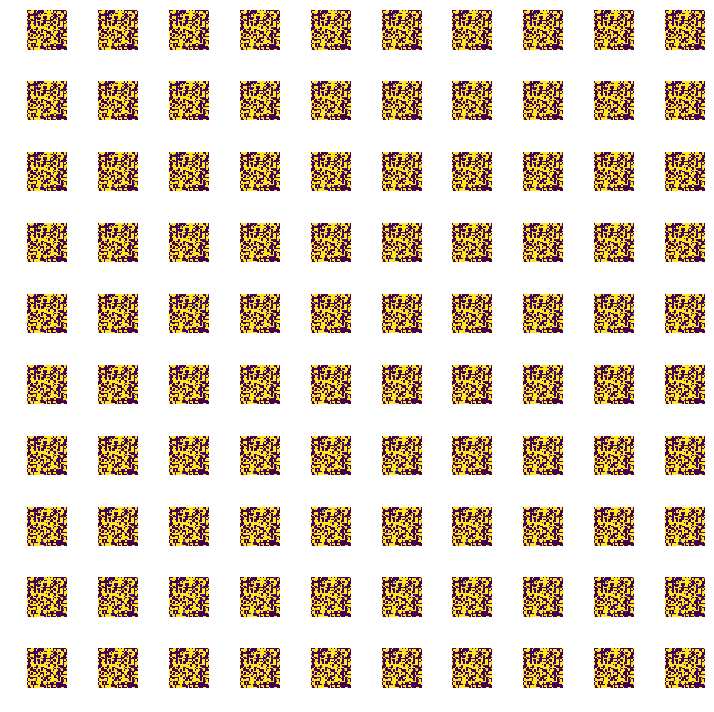

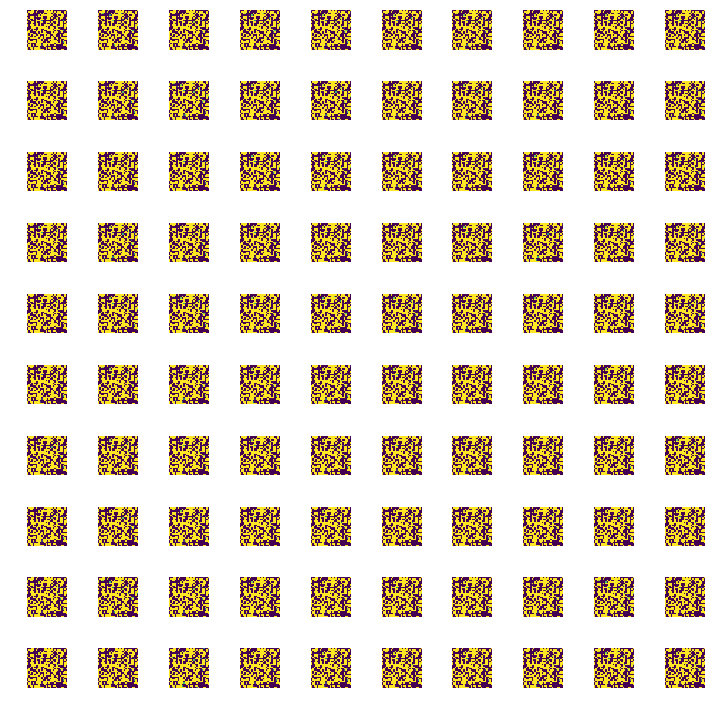

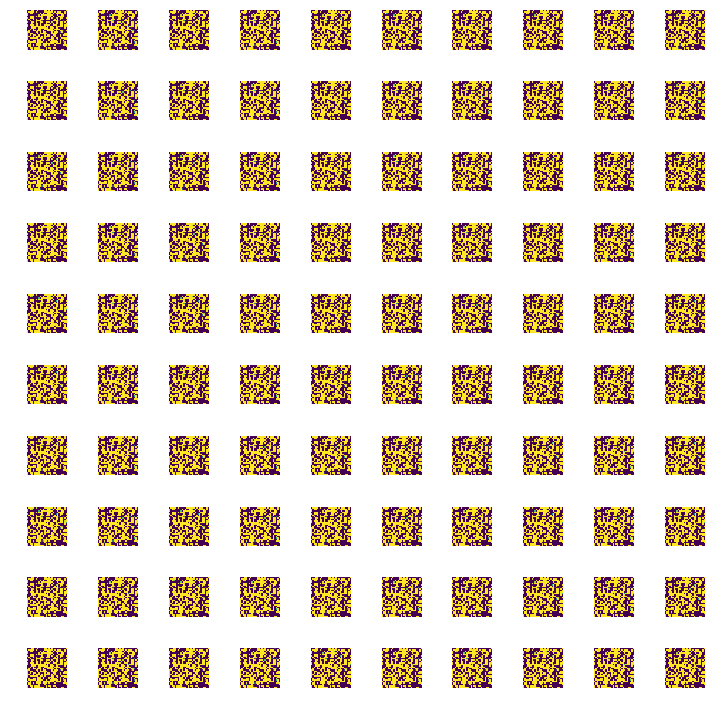

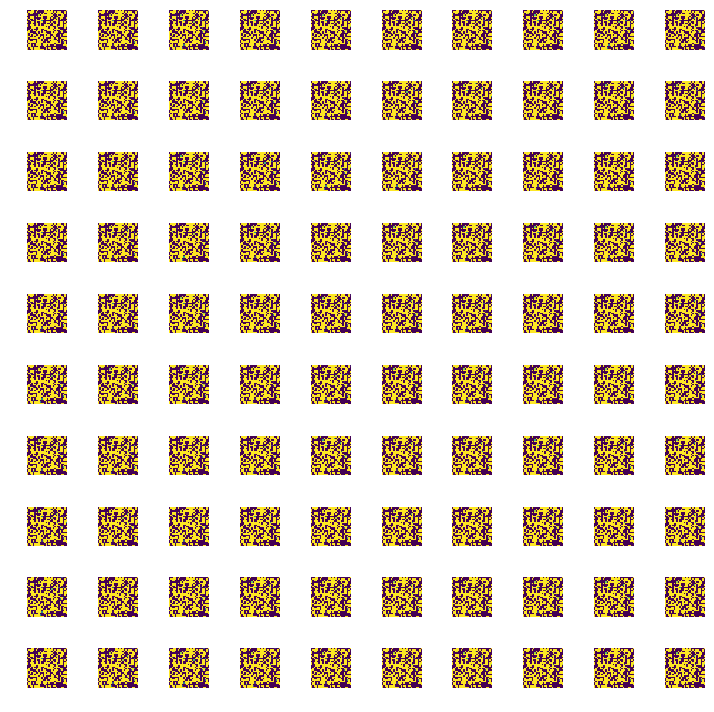

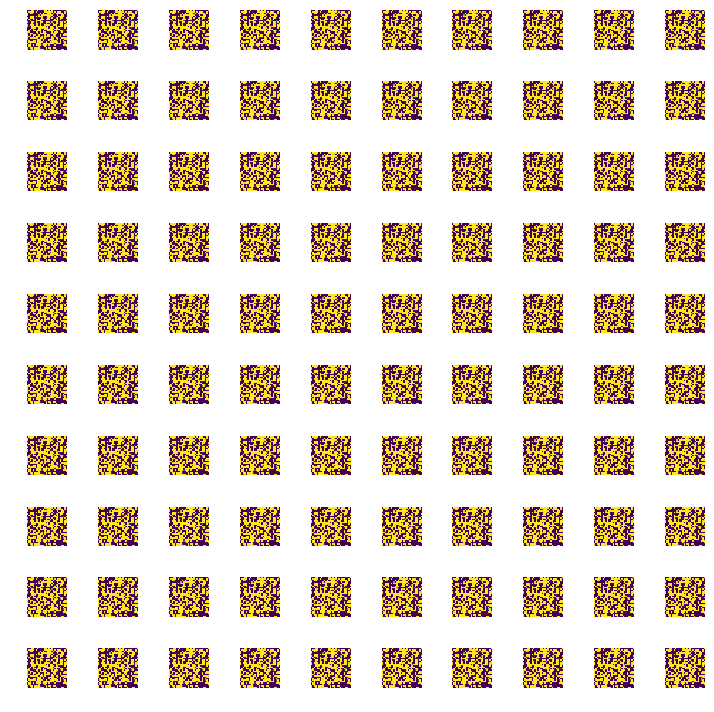

In [0]:
epochs=400

for e in range(1,epochs+1 ):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])

            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)

            # Get a random set of  images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]

            #Construct different mini-batches for real and fake, 
            #each mini-batch needs to contain only all real images or all generated images
            X= np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9

            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)

            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)

            discriminator.trainable=False
            gan.train_on_batch(noise, y_gen)

            print ("Epoc nª  ", e)
            if e == 1 or e % 20 == 0:
                plot_generated_images(e, generator)


